In [1]:
import pickle
import flask
import numpy as np
import pandas as pd
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pickle
import flask
import numpy

# loading data and predicted/testing labels from a file we created earlier
vectors = pickle.load(open("data.p", "rb"))
# Baseline Model
pred = pd.read_json('pred.json')
test = pd.read_json('test.json')
# Naive Bayes Model
pred = pd.read_json('pred.json')
test = pd.read_json('test.json')
# Frank Model
pred = pd.read_json('pred.json')
test = pd.read_json('test.json')

# TO-DO
#1. average ingredients vector for each cuisine
#2a. calculate distance between average vectors to set weight (???) look online
#2b. use mean absolute error/mean squared error (???) look online

#Later: Evaluate accuracy when (eg. 30% Chinese, 70% Japanese)

#print(model.predict(['salmon tomatoes']))
#print(vectors[0])

string_names = ['italian', 'mexican', 'southern_us', 'indian', 'chinese', 'french', 'cajun_creole',
                'thai', 'japanese', 'greek', 'spanish', 'korean', 'vietnamese', 'moroccan', 'british', 
                'filipino', 'irish', 'jamaican', 'russian', 'brazilian']

count_dict = {}

total_dict = {}
average_dict = {}
features = len(vectors[0]['vector'])

for str in string_names:
    if str not in average_dict:
        average_dict[str] = ([0] * features)
        total_dict[str] = ([0] * features)
    if str not in count_dict:
        count_dict[str] = 0

for recipe in vectors:
    total_dict[recipe['cuisine']] += recipe['vector']
    count_dict[recipe['cuisine']] += 1

for cuisine, average_arr in average_dict.items():
    average_dict[cuisine] = total_dict[cuisine]/count_dict[cuisine]

In [3]:
# Initialization of Global Variables
cuisine_to_ingredients = average_dict
n_cuisines = len(cuisine_to_ingredients.keys())
cuisine_types = list(cuisine_to_ingredients.keys())

# Create Similarity Matrix
def create_sim_mat(sim_method, n_cuis, cuis_types, cuis_to_ingred):
    """Returns a numpy array of shape n_cuisines by n_cuisines such that the 
    entry (i,j) indicates the similarity between cuisines i and j.
    
    Note: Diagonals are set to 0.0.
    
    Params: {sim_method: Function (of some similarity measure),
             n_cuis: Integer,
             cuis_types: List,
             cuis_to_ingred: Dict}
    Returns: Numpy array
    """
    matrix = np.zeros((n_cuis,n_cuis))
    for x in range(0,n_cuis):
        for y in range(0,n_cuis):
            if x == y:
                matrix[x,y] = 0.0
            else:
                matrix[x,y] = sim_method(cuis_types[x], cuis_types[y], cuis_to_ingred)
    return matrix

## Minkowski Distance (CURRENTLY NOT USED)

The Minkowski distance is a generalized form of the Euclidean distance (if p=2) and the Manhattan distance (if p=1).

$ \left(\sum_{i=1}^n |x_i-y_i|^p\right)^{1/p} $

Set exponent to 1 or 2 for Euclidean or Manhattan, or otherwise for Minkowski
exp = 1

def minkowski(cuis1, cuis2, cuis_to_ingred, p):
    """Returns a float giving similarity based on Minkowski Distance of 
       the two cuisine types.
    
    Params: {cuis1: String,
             cuis2: String,
             cuis_to_ingred: Dict
             p: Integer}
    Returns: Float (Jaccard similarity of the two cuisine types.)
    """
    cuisine1 = cuis_to_ingred[cuis1]
    cuisine2 = cuis_to_ingred[cuis2]
    distance = 0.0
    for i in range(0,len(cuisine1)):
        distance = distance + ((cuisine1[i]-cuisine2[i])**p)**(1.0/p)
    sim = 1/distance
    return sim

 Testing
print("Minkowski Similarity: Chinese vs. Korean")
print("======")
test1 = minkowski('chinese', 'korean', cuisine_to_ingredients, exp)
print(test1)

 Plot Heatmap of Simliarity Matrix
distance_sim_matrix = create_sim_mat(minkowski, n_cuisines, cuisine_types, cuisine_to_ingredients, exp)
plt.imshow(distance_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_cuisines), cuisine_types, rotation=90)
plt.yticks(range(n_cuisines), cuisine_types)
plt.show()

## Jaccard Similarity

$ J(A, B) = \frac{|A \cap B|}{|A \cup B|} $

In this case,

$ J(A, B) = \frac{\sum_{x \in \text{ingredients}} x \in A \,\text{and}\, x \in B}
{\sum_{x \in \text{ingredients}}x \in A \,\text{or}\, x \in B} $

In [4]:
def jaccard(cuis1, cuis2, cuis_to_ingred):
    """Returns a float giving the Jaccard similarity of 
       the two cuisine types.
    
    Params: {cuis1: String,
             cuis2: String,
             cuis_to_ingred: Dict}
    Returns: Float (Jaccard similarity of the two cuisine types.)
    """
    cuisine1 = cuis_to_ingred[cuis1]
    cuisine2 = cuis_to_ingred[cuis2]

    j_and, j_or = 0.0,0.0
    for i in range(0,len(cuisine1)):
        if (cuisine1[i]>0) and (cuisine2[i]>0):
            j_and += 1.0
            j_or += 1.0
        elif (cuisine1[i]>0) or (cuisine2[i]>0):
            j_or += 1.0
    j_sim = j_and/j_or
    return j_sim

In [5]:
# Testing
print("Jaccard Similarity: Chinese vs. Korean")
print("======")
test2 = jaccard('chinese', 'korean', cuisine_to_ingredients)
print(test2)

Jaccard Similarity: Chinese vs. Korean
0.45991253644314867


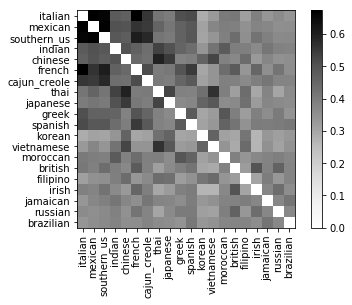

In [6]:
# Plot Heatmap of Simliarity Matrix
j_sim_matrix = create_sim_mat(jaccard, n_cuisines, cuisine_types, cuisine_to_ingredients)
plt.imshow(j_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_cuisines), cuisine_types, rotation=90)
plt.yticks(range(n_cuisines), cuisine_types)
plt.show()

## Generalized Jaccard Similarity

The similarity measure that we took above doesn't take into account how often each ingredient appears in recipes with a certain cuisine label. To account for this, we can use Generalized Jaccard, an extension of Jaccard to weighted sets.

For each ingredient $x$ and each cuisine $C$, we compute the frequency weight $\text{tf}(x, C)$ as the ratio between the number of times recipes with label $C$ contains $x$, and the total number of ingredients used in $C$.

Generalized Jaccard is:

$ GJ(A, B) = \frac{\sum_{x \in \text{ingredients}} \text{min}(\text{tf}(x, A), \text{tf}(x, B))}
{\sum_{x \in \text{ingredients}} \text{max}(\text{tf}(x, A), \text{tf}(x, B))} $

Note that Jaccard is equivalent to Generalized Jaccard if the weights are binarized by truncating all positive weights to 1.

In [7]:
def g_jaccard(cuis1, cuis2, cuis_to_ingred):
    """Returns a float giving the Generalized Jaccard similarity of 
       the two cuisine types.
    
    Params: {cuis1: String,
             cuis2: String,
             cuis_to_ingred: Dict}
    Returns: Float (Generalized Jaccard similarity of the two cuisine types.)
    """
    cuisine1 = cuis_to_ingred[cuis1]
    cuisine2 = cuis_to_ingred[cuis2]
    den1 = float(np.sum(cuisine1))
    den2 = float(np.sum(cuisine2))

    gj_num, gj_den = 0.0,0.0
    for i in range(0,len(cuisine1)):
        tf1 = float(cuisine1[i])/den1
        tf2 = float(cuisine2[i])/den2
        gj_num += min(tf1, tf2)
        gj_den += max(tf1, tf2)
    gj_sim = gj_num/gj_den
    return gj_sim

In [8]:
# Testing
print("Generalized Jaccard Similarity: Chinese vs. Korean")
print("======")
test3 = g_jaccard('chinese', 'korean', cuisine_to_ingredients)
print(test3)

Generalized Jaccard Similarity: Chinese vs. Korean
0.47905040627249207


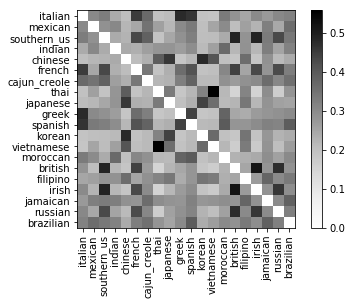

In [9]:
# Plot Heatmap of Simliarity Matrix
gj_sim_matrix = create_sim_mat(g_jaccard, n_cuisines, cuisine_types, cuisine_to_ingredients)
plt.imshow(gj_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_cuisines), cuisine_types, rotation=90)
plt.yticks(range(n_cuisines), cuisine_types)
plt.show()

## Cosine Similarity

$ cossim(\vec{a}, \vec{b}) = \frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\| \cdot \|\vec{b}\|}$

Specifically, focusing on the numerator...

$ \vec{a} \cdot \vec{b} = \sum_{i} {a_i} * {b_i} $

In [10]:
def cossim(cuis1, cuis2, cuis_to_ingred):
    """Returns a float giving the Cosine similarity of 
       the two cuisine types.
    
    Params: {cuis1: String,
             cuis2: String,
             cuis_to_ingred: Dict}
    Returns: Float (Cosine similarity of the two cuisine types.)
    """
    cuisine1 = cuis_to_ingred[cuis1]
    cuisine2 = cuis_to_ingred[cuis2]
    cos_sim = (cuisine1*cuisine2).sum()
    #with denominator (consideration of vector magnitudes)
    cuis1_mag = LA.norm(cuisine1)
    cuis2_mag = LA.norm(cuisine2)
    cos_sim = cos_sim/(cuis1_mag*cuis2_mag)
    return cos_sim

In [11]:
# Testing
print("Cosine Similarity: Chinese vs. Korean")
print("======")
test4 = cossim('chinese', 'korean', cuisine_to_ingredients)
print(test4)

Cosine Similarity: Chinese vs. Korean
0.862525172617


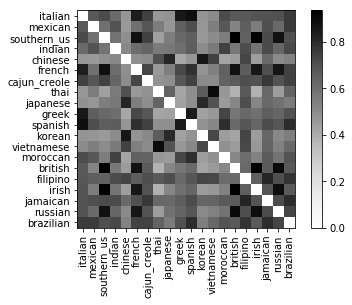

In [12]:
# Plot Heatmap of Simliarity Matrix
cos_sim_matrix = create_sim_mat(cossim, n_cuisines, cuisine_types, cuisine_to_ingredients)
plt.imshow(cos_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_cuisines), cuisine_types, rotation=90)
plt.yticks(range(n_cuisines), cuisine_types)
plt.show()

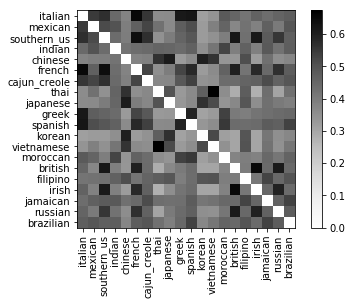

Average Similarity
0.44172032731


In [13]:
# Combining the 3 Simliarity Matrices
comb_sim_matrix = (j_sim_matrix + gj_sim_matrix + cos_sim_matrix)/3.0
plt.imshow(comb_sim_matrix, interpolation='none',
           cmap=plt.cm.Greys)
plt.colorbar()

plt.xticks(range(n_cuisines), cuisine_types, rotation=90)
plt.yticks(range(n_cuisines), cuisine_types)
plt.show()

# Average Similarity
print("Average Similarity")
print("======")
avg_sim = comb_sim_matrix.sum()/(n_cuisines**2-n_cuisines)
print(avg_sim)

In [14]:
# Build inverted index
def build_inv_idx(lst):
    """ Builds an inverted index from the messages.
    
    Params: {lst: List}
    Returns: Dict (an inverted index of cuisine types)
    """
    inverted_idx = {}
    for idx in range(0,len(lst)):
        inverted_idx[lst[idx]] = idx
    return inverted_idx

cuis_inv_idx = build_inv_idx(cuisine_types)
print(cuis_inv_idx)

{'italian': 0, 'mexican': 1, 'southern_us': 2, 'indian': 3, 'chinese': 4, 'french': 5, 'cajun_creole': 6, 'thai': 7, 'japanese': 8, 'greek': 9, 'spanish': 10, 'korean': 11, 'vietnamese': 12, 'moroccan': 13, 'british': 14, 'filipino': 15, 'irish': 16, 'jamaican': 17, 'russian': 18, 'brazilian': 19}


In [15]:
# EVALUATION
def eval(pred, test, sim_cutoff):
    pred_list = []
    test_list = []
    count = 0
    for index, row in pred.iterrows():
        pred_list.append(row[0])
    for index, row in test.iterrows():
        test_list.append(row[0])
    for i in range(0, len(pred_list)):
        #print(pred_list[i])
        #print(test_list[i])
        if(pred_list[i] == test_list[i]):
            count += 1.0
        else:
            a = cuis_inv_idx[pred_list[i]]
            b = cuis_inv_idx[test_list[i]]
            sim = comb_sim_matrix[a,b]
            if sim > sim_cutoff:
                count += sim**2 # TWEAK REWARD HERE
    accuracy = count/len(pred_list)
    return accuracy

In [17]:
# Setting Cutoff Values
cutoff_none = 0.0
cutoff_avg = avg_sim
cutoff_high = 0.6
cutoff_test = 0.65
cutoff_noreward = 1.0

print("Baseline Model Accuracy")
print("==============================")
print("No cutoff:")
print("0.0")
print("=======================")

print("Average cutoff:")
print("0.0")
print("=======================")

print("60% cutoff:")
print("0.0")
print("=======================")

print("65% cutoff:")
print("0.0")
print("=======================")

print("No reward:")
print("0.0")
print("=======================")

print("")
print("")

print("Naive Bayes Model Accuracy")
print("==============================")
print("No cutoff:")
print(eval(pred, test, cutoff_none))
print("=======================")

print("Average cutoff:")
print(eval(pred, test, cutoff_avg))
print("=======================")

print("60% cutoff:")
print(eval(pred, test, cutoff_high))
print("=======================")

print("65% cutoff:")
print(eval(pred, test, cutoff_test))
print("=======================")

print("No reward:")
print(eval(pred, test, cutoff_noreward))
print("=======================")


print("")
print("")

print("Frank Model Accuracy")
print("==============================")
print("No cutoff:")
print("0.0")
print("=======================")

print("Average cutoff:")
print("0.0")
print("=======================")

print("60% cutoff:")
print("0.0")
print("=======================")

print("65% cutoff:")
print("0.0")
print("=======================")

print("No reward:")
print("0.0")
print("=======================")

Baseline Model Accuracy
No cutoff:
0.0
Average cutoff:
0.0
60% cutoff:
0.0
65% cutoff:
0.0
No reward:
0.0


Naive Bayes Model Accuracy
No cutoff:
0.801934844172
Average cutoff:
0.796175189013
60% cutoff:
0.752942932534
65% cutoff:
0.730433415103
No reward:
0.7151455127228402


Frank Model Accuracy
No cutoff:
0.0
Average cutoff:
0.0
60% cutoff:
0.0
65% cutoff:
0.0
No reward:
0.0
